In [1]:
# Load data
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_excel('GTD_0617dist/globalterrorismdb_0617dist.xlsx',
                   index_col=0,na_values = ['Unknown','-99','-9','Not Applicable'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170350 entries, 197000000001 to 201701270001
Columns: 134 entries, iyear to related
dtypes: datetime64[ns](1), float64(53), int64(23), object(57)
memory usage: 175.5+ MB


In [2]:
# create a date column, then get rid of the seaparte year, month and day columns
# entries without month or day - treat as 1st January
df['imonth'].replace(0,1,inplace=True)
df['iday'].replace(0,1,inplace=True)

# replace some values not correctly dealt with by pandas import
df.replace(-9,np.nan,inplace=True)
df.replace(-99,np.nan,inplace=True)

df['iyear']=pd.to_datetime(dict(year=df.iyear, month=df.imonth, day=df.iday)) 
df.rename(columns={'iyear':'date'}, inplace=True)

# extract columns of interest
cols_to_extract = ['date',
 'country_txt','region_txt','provstate','city','latitude','longitude',
 'crit1','crit2','crit3',
 'attacktype1_txt','attacktype2_txt','attacktype3_txt',
 'success','suicide',
 'weaptype1_txt','weapsubtype1_txt','weaptype2_txt','weapsubtype2_txt','weaptype3_txt','weapsubtype3_txt','weaptype4_txt','weapsubtype4_txt',
 'targtype1_txt','targsubtype1_txt','corp1','target1','natlty1_txt',
 'targtype2_txt','targsubtype2_txt','corp2','target2','natlty2_txt',
 'targtype3_txt','targsubtype3_txt','corp3','target3','natlty3_txt',
 'gname','gsubname','gname2','gsubname2','gname3','gsubname3',
 'individual','nperps','nperpcap',
 'claimed','claim2','claim3',
 'nkill','nkillter','nwound','nwoundte',
 'property','propextent_txt','propvalue',
 'ishostkid','nhostkid','nhours','ndays','kidhijcountry',
 'ransom','ransomamt','ransompaid','hostkidoutcome_txt','nreleased']

df = df[cols_to_extract]

In [3]:
# look at the most common values in each column
for column in df.columns:
    print('=============',column,'=============')
    display(df[column].value_counts().head())

============= date =============


2016-09-21    129
2016-12-01    100
2014-06-14     96
2016-08-08     90
2013-10-09     89
Name: date, dtype: int64

============= country_txt =============


Iraq           22130
Pakistan       13634
Afghanistan    11306
India          10978
Colombia        8163
Name: country_txt, dtype: int64

============= region_txt =============


Middle East & North Africa    46511
South Asia                    41497
South America                 18762
Western Europe                16307
Sub-Saharan Africa            15491
Name: region_txt, dtype: int64

============= provstate =============


Baghdad             7238
Northern Ireland    4405
Balochistan         3377
Sindh               3146
Saladin             3103
Name: provstate, dtype: int64

============= city =============


Baghdad    7206
Karachi    2609
Lima       2358
Belfast    2140
Mosul      1775
Name: city, dtype: int64

============= latitude =============


 33.300000    2240
-12.046378    2234
 54.597269    1949
 13.692880    1559
-33.469115    1519
Name: latitude, dtype: int64

============= longitude =============


-77.042791    2234
 44.400000    2211
-5.930109     1948
-89.199161    1559
-70.641997    1522
Name: longitude, dtype: int64

============= crit1 =============


1    168381
0      1969
Name: crit1, dtype: int64

============= crit2 =============


1    169155
0      1195
Name: crit2, dtype: int64

============= crit3 =============


1    149877
0     20473
Name: crit3, dtype: int64

============= attacktype1_txt =============


Bombing/Explosion                 83073
Armed Assault                     40223
Assassination                     18402
Hostage Taking (Kidnapping)       10233
Facility/Infrastructure Attack     9581
Name: attacktype1_txt, dtype: int64

============= attacktype2_txt =============


Armed Assault                     3056
Facility/Infrastructure Attack    1371
Bombing/Explosion                  485
Hostage Taking (Kidnapping)        479
Assassination                      161
Name: attacktype2_txt, dtype: int64

============= attacktype3_txt =============


Facility/Infrastructure Attack    185
Armed Assault                     110
Hostage Taking (Kidnapping)        53
Bombing/Explosion                  16
Hijacking                           4
Name: attacktype3_txt, dtype: int64

============= success =============


1    152701
0     17649
Name: success, dtype: int64

============= suicide =============


0    164580
1      5770
Name: suicide, dtype: int64

============= weaptype1_txt =============


Explosives/Bombs/Dynamite    86704
Firearms                     55273
Incendiary                   10459
Melee                         3338
Chemical                       293
Name: weaptype1_txt, dtype: int64

============= weapsubtype1_txt =============


Unknown Explosive Type                       42897
Unknown Gun Type                             30497
Automatic Weapon                             17140
Vehicle                                       9210
Projectile (rockets, mortars, RPGs, etc.)     9183
Name: weapsubtype1_txt, dtype: int64

============= weaptype2_txt =============


Firearms                     4778
Explosives/Bombs/Dynamite    2763
Incendiary                   2084
Melee                        1274
Other                         107
Name: weaptype2_txt, dtype: int64

============= weapsubtype2_txt =============


Unknown Gun Type               2362
Automatic Weapon               1643
Arson/Fire                     1325
Unknown Explosive Type          996
Knife or Other Sharp Object     795
Name: weapsubtype2_txt, dtype: int64

============= weaptype3_txt =============


Firearms                     722
Incendiary                   311
Melee                        303
Explosives/Bombs/Dynamite    199
Other                         35
Name: weaptype3_txt, dtype: int64

============= weapsubtype3_txt =============


Unknown Gun Type               275
Automatic Weapon               263
Knife or Other Sharp Object    214
Arson/Fire                     156
Handgun                         90
Name: weapsubtype3_txt, dtype: int64

============= weaptype4_txt =============


Firearms                     29
Explosives/Bombs/Dynamite    27
Incendiary                   10
Melee                         7
Other                         1
Name: weaptype4_txt, dtype: int64

============= weapsubtype4_txt =============


Automatic Weapon                             16
Unknown Explosive Type                       11
Projectile (rockets, mortars, RPGs, etc.)     7
Unknown Gun Type                              6
Grenade                                       6
Name: weapsubtype4_txt, dtype: int64

============= targtype1_txt =============


Private Citizens & Property    39994
Military                       25508
Police                         22938
Government (General)           20314
Business                       19873
Name: targtype1_txt, dtype: int64

============= targsubtype1_txt =============


Unnamed Civilian/Unspecified                               10842
Police Security Forces/Officers                            10625
Military Unit/Patrol/Convoy                                 7881
Military Personnel (soldiers, troops, officers, forces)     7184
Government Personnel (excluding police, military)           6288
Name: targsubtype1_txt, dtype: int64

============= corp1 =============


Iraqi Police Service (IPS)    3182
Govt                          2786
Civilians                     2783
Police                        2571
Military                      2118
Name: corp1, dtype: int64

============= target1 =============


Civilians     5810
Soldiers      2688
Patrol        2616
Checkpoint    2562
Vehicle       2397
Name: target1, dtype: int64

============= natlty1_txt =============


Iraq           21625
Pakistan       13168
India          11110
Afghanistan     9669
Colombia        7783
Name: natlty1_txt, dtype: int64

============= targtype2_txt =============


Private Citizens & Property    4937
Military                       1123
Police                         1012
Business                        812
Government (General)            457
Name: targtype2_txt, dtype: int64

============= targsubtype2_txt =============


Judge/Attorney/Court               2981
Unnamed Civilian/Unspecified        990
Multinational Corporation           738
Bank/Commerce                       471
Police Security Forces/Officers     457
Name: targsubtype2_txt, dtype: int64

============= corp2 =============


Civilians                     708
Iraqi Volunteer Forces        157
Somali National Army (SNA)    110
Afghan Police                  84
Civilian                       80
Name: corp2, dtype: int64

============= target2 =============


Civilians    2044
Soldiers      240
Civilian      232
Members       222
Officers      168
Name: target2, dtype: int64

============= natlty2_txt =============


Iraq           1647
Afghanistan    1213
Pakistan        682
India           583
Somalia         525
Name: natlty2_txt, dtype: int64

============= targtype3_txt =============


Private Citizens & Property    467
Business                       110
Police                          93
Military                        79
Government (General)            74
Name: targtype3_txt, dtype: int64

============= targsubtype3_txt =============


Unnamed Civilian/Unspecified                               273
Police Security Forces/Officers                             73
Military Personnel (soldiers, troops, officers, forces)     53
Laborer (General)/Occupation Identified                     45
House/Apartment/Residence                                   39
Name: targsubtype3_txt, dtype: int64

============= corp3 =============


Civilians                           75
Christian Religious Denomination    25
Civilian                            10
Afghan Police                        8
Etisalat                             6
Name: corp3, dtype: int64

============= target3 =============


Civilians      160
1 orphanage     25
Members         22
Civilian        16
Soldiers        15
Name: target3, dtype: int64

============= natlty3_txt =============


Iraq           124
Afghanistan    108
Pakistan        51
India           50
Colombia        47
Name: natlty3_txt, dtype: int64

============= gname =============


Taliban                                             6575
Shining Path (SL)                                   4551
Islamic State of Iraq and the Levant (ISIL)         4287
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          2683
Name: gname, dtype: int64

============= gsubname =============


Militants                           480
People's Liberation Forces (FPL)    427
Rebels                              163
Separatists                         120
Guerrillas                          101
Name: gsubname, dtype: int64

============= gname2 =============


Al-Nusrah Front                                56
Badr Brigades                                  52
National Liberation Army of Colombia (ELN)     48
Islamic State of Iraq and the Levant (ISIL)    42
Palestinian Islamic Jihad (PIJ)                37
Name: gname2, dtype: int64

============= gsubname2 =============


The Family                                   20
Intifadat Ahrar al-Iraq                      10
al-Quds Brigades                             10
Forces for the Defense of Democracy (FDD)     9
Jamaat-ul-Ahrar                               8
Name: gsubname2, dtype: int64

============= gname3 =============


National Democratic Alliance Army (NDAA-ESSA)    15
Islamic State of Iraq and the Levant (ISIL)      14
Free Syrian Army                                 13
Lashkar-e-Taiba (LeT)                            13
Al-Nusrah Front                                  11
Name: gname3, dtype: int64

============= gsubname3 =============


Jaish al-Muhajireen wal-Ansar (Muhajireen Army)    1
Ezzedine al-Qassam Brigades                        1
Turkistan Islamic Party (Syria)                    1
Al-Alami                                           1
Al-Izzah; Jaish al-Tahrir                          1
Name: gsubname3, dtype: int64

============= individual =============


0    169927
1       423
Name: individual, dtype: int64

============= nperps =============


1.0    7517
2.0    5611
3.0    2626
4.0    2084
5.0    1013
Name: nperps, dtype: int64

============= nperpcap =============


0.0    95558
1.0     1723
2.0      723
3.0      372
4.0      255
Name: nperpcap, dtype: int64

============= claimed =============


0.0    86578
1.0    16164
Name: claimed, dtype: int64

============= claim2 =============


0.0    1073
1.0     528
Name: claim2, dtype: int64

============= claim3 =============


0.0    145
1.0    118
Name: claim3, dtype: int64

============= nkill =============


0.0    82925
1.0    34256
2.0    13247
3.0     7170
4.0     4580
Name: nkill, dtype: int64

============= nkillter =============


0.0    92301
1.0     5931
2.0     1630
3.0      918
4.0      572
Name: nkillter, dtype: int64

============= nwound =============


0.0    97182
1.0    14856
2.0     9387
3.0     6673
4.0     4470
Name: nwound, dtype: int64

============= nwoundte =============


0.0    99573
1.0      770
2.0      331
3.0      221
4.0      132
Name: nwoundte, dtype: int64

============= property =============


1.0    90019
0.0    60752
Name: property, dtype: int64

============= propextent_txt =============


Minor (likely < $1 million)                     40569
Major (likely > $1 million but < $1 billion)      904
Catastrophic (likely > $1 billion)                  6
Name: propextent_txt, dtype: int64

============= propvalue =============


50000.0    1185
10000.0     804
20000.0     756
5000.0      578
30000.0     556
Name: propvalue, dtype: int64

============= ishostkid =============


0.0    157411
1.0     12492
Name: ishostkid, dtype: int64

============= nhostkid =============


1.0    5073
2.0    1690
3.0     945
4.0     676
5.0     426
Name: nhostkid, dtype: int64

============= nhours =============


0.0    1293
1.0     184
2.0     101
3.0      61
4.0      43
Name: nhours, dtype: int64

============= ndays =============


1.0    739
2.0    405
3.0    292
0.0    225
4.0    196
Name: ndays, dtype: int64

============= kidhijcountry =============


Colombia       687
Guatemala      204
Philippines    183
India          143
Lebanon        139
Name: kidhijcountry, dtype: int64

============= ransom =============


0.0    73726
1.0     1229
Name: ransom, dtype: int64

============= ransomamt =============


0.0          339
1000000.0     30
500000.0      23
2000000.0     20
5000000.0     18
Name: ransomamt, dtype: int64

============= ransompaid =============


0.0          234
1000000.0      7
100000.0       6
500000.0       5
38500.0        5
Name: ransompaid, dtype: int64

============= hostkidoutcome_txt =============


Hostage(s) released by perpetrators               2849
Hostage(s) killed (not during rescue attempt)     2229
Combination                                        906
Successful Rescue                                  496
Hostage(s) escaped (not during rescue attempt)     156
Name: hostkidoutcome_txt, dtype: int64

============= nreleased =============


0.0    2018
1.0    1926
2.0     616
3.0     350
4.0     239
Name: nreleased, dtype: int64

In [4]:
# Some rows are identical to each other.
# E.g. 100 duplicates of GTD ID 201609210029. In this case seems to be
# 100 separte incidents of an explosive being detonated in a civilian
# house. So I will treat the duplicates as genuine.
dups = df.duplicated(keep=False) # don't include GTD ID when testing duplicates
print('There are',dups.sum(),'rows which have duplicated information in other rows.')

There are 11864 rows which have duplicated information in other rows.


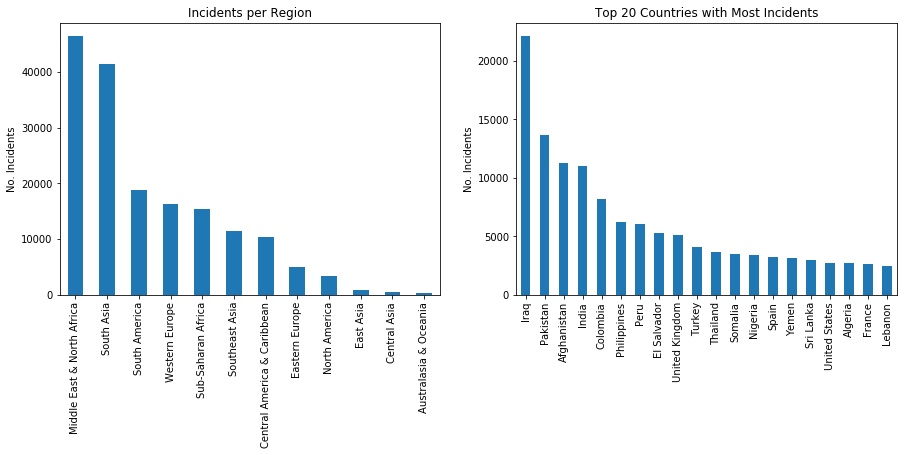

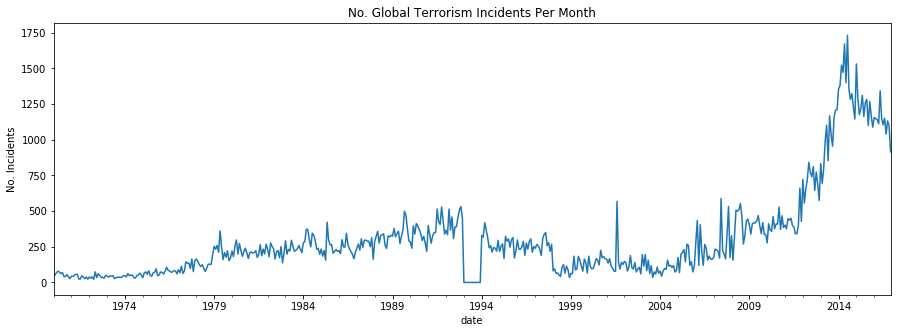

In [5]:
# Plot some basic stats
# No. of incidents per region and over time

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['region_txt'].value_counts().plot.bar(title='Incidents per Region')
plt.ylabel('No. Incidents')

plt.subplot(1,2,2)
df['country_txt'].value_counts()[:20].plot.bar(title='Top 20 Countries with Most Incidents')
plt.ylabel('No. Incidents')

plt.figure(figsize=(15,5))
attacks_month = df.resample('M',on='date')['date'].count().plot(title='No. Global Terrorism Incidents Per Month')
plt.ylabel('No. Incidents');

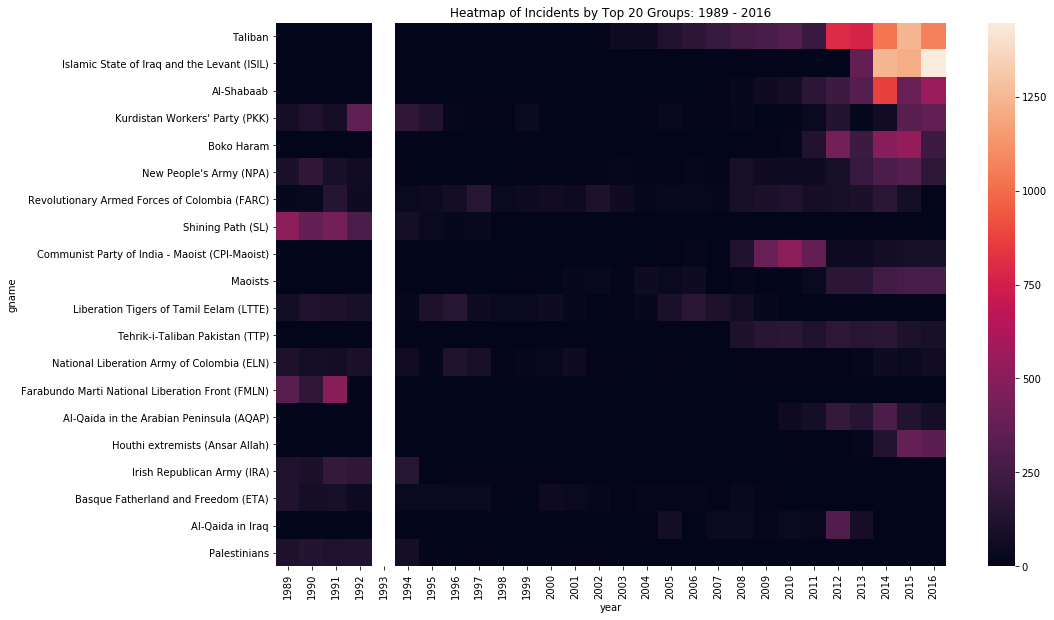

In [93]:
# Different groups

# incidents per year for top 20 groups
group_year = df.groupby([pd.Grouper(freq='A',key='date'),'gname'])['country_txt'].count()
group_year = group_year.unstack('gname',fill_value=0)

group_year.name = 'n_incidents'
group_year.index = group_year.index.year
group_year.index.name = 'year'

year_range = list(np.arange(1989,2017))
n_groups = 20
plot_groups = group_year.loc[year_range].sum().sort_values(ascending=False)[:n_groups].index.tolist()
plt.figure(figsize=(15,10))
sns.heatmap(tmp[plot_groups].loc[year_range].T)
plt.title('Heatmap of Incidents by Top 20 Groups: {} - {}'.format(min(year_range),max(year_range)));
